---
execute:
  cache: false
  eval: true
  echo: true
  warning: false
jupyter: python3
---

# Hyperparameter Tuning with `spotpython` and `PyTorch` Lightning for the Diabetes Data Set {#sec-hpt-pytorch}

In this section, we will show how `spotpython` can be integrated into the `PyTorch` Lightning
training workflow for a regression task.
It demonstrates how easy it is to use `spotpython` to tune hyperparameters for a `PyTorch` Lightning model.

## The Basic Setting {#sec-basic-setup-601}


In [ ]:
#| label: 601_imports
import os
from math import inf
import warnings
warnings.filterwarnings("ignore")

After importing the necessary libraries, the `fun_control` dictionary is set up via the `fun_control_init` function.
The `fun_control` dictionary contains

* `PREFIX`: a unique identifier for the experiment
* `fun_evals`: the number of function evaluations
* `max_time`: the maximum run time in minutes
* `data_set`: the data set. Here we use the `Diabetes` data set that is provided by `spotpython`.
* `core_model_name`: the class name of the neural network model. This neural network model is provided by `spotpython`.
* `hyperdict`: the hyperparameter dictionary. This dictionary is used to define the hyperparameters of the neural network model. It is also provided by `spotpython`.
* `_L_in`: the number of input features. Since the `Diabetes` data set has 10 features, `_L_in` is set to 10.
* `_L_out`: the number of output features. Since we want to predict a single value, `_L_out` is set to 1.

The `HyperLight` class is used to define the objective function `fun`.
It connects the `PyTorch` and the `spotpython` methods and is provided by `spotpython`.

In [ ]:
#| label: 601_spotpython_setup

from spotpython.data.diabetes import Diabetes
from spotpython.hyperdict.light_hyper_dict import LightHyperDict
from spotpython.fun.hyperlight import HyperLight
from spotpython.utils.init import (fun_control_init, surrogate_control_init, design_control_init)
from spotpython.utils.eda import gen_design_table
from spotpython.spot import Spot
from spotpython.utils.file import get_experiment_filename

PREFIX="601"

data_set = Diabetes()

fun_control = fun_control_init(
    PREFIX=PREFIX,
    fun_evals=inf,
    max_time=1,
    data_set = data_set,
    core_model_name="light.regression.NNLinearRegressor",
    hyperdict=LightHyperDict,
    _L_in=10,
    _L_out=1)

fun = HyperLight().fun

Seed set to 123
Seed set to 123


module_name: light
submodule_name: regression
model_name: NNLinearRegressor


The method `set_hyperparameter` allows the user to modify default hyperparameter settings.
Here we modify some hyperparameters to keep the model small and to decrease the tuning time.

In [ ]:
from spotpython.hyperparameters.values import set_hyperparameter
set_hyperparameter(fun_control, "optimizer", [ "Adadelta", "Adam", "Adamax"])
set_hyperparameter(fun_control, "l1", [3,4])
set_hyperparameter(fun_control, "epochs", [3,7])
set_hyperparameter(fun_control, "batch_size", [4,11])
set_hyperparameter(fun_control, "dropout_prob", [0.0, 0.025])
set_hyperparameter(fun_control, "patience", [2,3])

design_control = design_control_init(init_size=10)

print(gen_design_table(fun_control))

| name           | type   | default   |   lower |   upper | transform             |
|----------------|--------|-----------|---------|---------|-----------------------|
| l1             | int    | 3         |     3   |   4     | transform_power_2_int |
| epochs         | int    | 4         |     3   |   7     | transform_power_2_int |
| batch_size     | int    | 4         |     4   |  11     | transform_power_2_int |
| act_fn         | factor | ReLU      |     0   |   5     | None                  |
| optimizer      | factor | SGD       |     0   |   2     | None                  |
| dropout_prob   | float  | 0.01      |     0   |   0.025 | None                  |
| lr_mult        | float  | 1.0       |     0.1 |  10     | None                  |
| patience       | int    | 2         |     2   |   3     | transform_power_2_int |
| batch_norm     | factor | 0         |     0   |   1     | None                  |
| initialization | factor | Default   |     0   |   4     | None            

Finally, a `Spot` object is created.
Calling the method `run()` starts the hyperparameter tuning process.

In [ ]:
#| label: 601_run
S = Spot(fun=fun,fun_control=fun_control, design_control=design_control)
S.run()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 202 K  | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
202 K     Trainable params
0         Non-trainable params
202 K     Total params
0.812     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Experiment saved to 601_exp.pkl


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 23075.166015625, 'hp_metric': 23075.166015625}


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 205 K  | train | [256, 10] | [256, 1] 
----------------------------------------------------------------------
205 K     Trainable params
0         Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3600.9345703125, 'hp_metric': 3600.9345703125}


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 53.2 K | train | [512, 10] | [512, 1] 
----------------------------------------------------------------------
53.2 K    Trainable params
0         Non-trainable params
53.2 K    Total params
0.213     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 4820.04443359375, 'hp_metric': 4820.04443359375}


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 205 K  | train | [128, 10] | [128, 1] 
----------------------------------------------------------------------
205 K     Trainable params
0         Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 24072.69140625, 'hp_metric': 24072.69140625}


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 202 K  | train | [32, 10] | [32, 1]  
---------------------------------------------------------------------
202 K     Trainable params
0         Non-trainable params
202 K     Total params
0.812     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 22493.71875, 'hp_metric': 22493.71875}


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [512, 10] | [512, 1] 
----------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=8` reached.


train_model result: {'val_loss': 4145.4853515625, 'hp_metric': 4145.4853515625}


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 53.2 K | train | [32, 10] | [32, 1]  
---------------------------------------------------------------------
53.2 K    Trainable params
0         Non-trainable params
53.2 K    Total params
0.213     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 20313.955078125, 'hp_metric': 20313.955078125}


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [128, 10] | [128, 1] 
----------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 4382.205078125, 'hp_metric': 4382.205078125}


`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 205 K  | train | [1024, 10] | [1024, 1]
-----------------------------------------------------------------------
205 K     Trainable params
0         Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 20690.306640625, 'hp_metric': 20690.306640625}


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 24063.02734375, 'hp_metric': 24063.02734375}
train_model result: {'val_loss': 3323.162353515625, 'hp_metric': 3323.162353515625}
spotpython tuning: 3323.162353515625 [----------] 0.98% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3555.804443359375, 'hp_metric': 3555.804443359375}
spotpython tuning: 3323.162353515625 [----------] 2.80% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [1024, 10] | [1024, 1]
-----------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=8` reached.


train_model result: {'val_loss': 24033.90625, 'hp_metric': 24033.90625}
spotpython tuning: 3323.162353515625 [----------] 4.05% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3263.774169921875, 'hp_metric': 3263.774169921875}
spotpython tuning: 3263.774169921875 [#---------] 5.62% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 10676.2216796875, 'hp_metric': 10676.2216796875}
spotpython tuning: 3263.774169921875 [#---------] 6.81% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3352.18505859375, 'hp_metric': 3352.18505859375}
spotpython tuning: 3263.774169921875 [#---------] 8.33% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 4080.423828125, 'hp_metric': 4080.423828125}
spotpython tuning: 3263.774169921875 [#---------] 9.65% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=32` reached.


train_model result: {'val_loss': 3483.333740234375, 'hp_metric': 3483.333740234375}
spotpython tuning: 3263.774169921875 [#---------] 12.29% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 21503.978515625, 'hp_metric': 21503.978515625}
spotpython tuning: 3263.774169921875 [#---------] 13.40% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [128, 10] | [128, 1] 
----------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=8` reached.


train_model result: {'val_loss': 40124.15234375, 'hp_metric': 40124.15234375}
spotpython tuning: 3263.774169921875 [#---------] 14.41% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=32` reached.


train_model result: {'val_loss': 3363.0498046875, 'hp_metric': 3363.0498046875}
spotpython tuning: 3263.774169921875 [##--------] 16.78% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3517.5087890625, 'hp_metric': 3517.5087890625}
spotpython tuning: 3263.774169921875 [##--------] 18.71% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=32` reached.


train_model result: {'val_loss': 21383.916015625, 'hp_metric': 21383.916015625}
spotpython tuning: 3263.774169921875 [##--------] 20.93% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3492.506591796875, 'hp_metric': 3492.506591796875}
spotpython tuning: 3263.774169921875 [##--------] 22.36% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3307.992431640625, 'hp_metric': 3307.992431640625}
spotpython tuning: 3263.774169921875 [##--------] 24.05% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3643.89111328125, 'hp_metric': 3643.89111328125}
spotpython tuning: 3263.774169921875 [###-------] 25.94% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3387.20703125, 'hp_metric': 3387.20703125}
spotpython tuning: 3263.774169921875 [###-------] 27.73% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3335.376220703125, 'hp_metric': 3335.376220703125}
spotpython tuning: 3263.774169921875 [###-------] 29.67% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3228.65966796875, 'hp_metric': 3228.65966796875}
spotpython tuning: 3228.65966796875 [###-------] 31.48% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3304.39404296875, 'hp_metric': 3304.39404296875}
spotpython tuning: 3228.65966796875 [###-------] 33.58% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3975.175048828125, 'hp_metric': 3975.175048828125}
spotpython tuning: 3228.65966796875 [####------] 35.53% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 19447.30859375, 'hp_metric': 19447.30859375}
spotpython tuning: 3228.65966796875 [####------] 36.96% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 5898.79736328125, 'hp_metric': 5898.79736328125}
spotpython tuning: 3228.65966796875 [####------] 39.17% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3406.994140625, 'hp_metric': 3406.994140625}
spotpython tuning: 3228.65966796875 [####------] 41.28% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3523.98828125, 'hp_metric': 3523.98828125}
spotpython tuning: 3228.65966796875 [####------] 43.07% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 21379.70703125, 'hp_metric': 21379.70703125}
spotpython tuning: 3228.65966796875 [#####-----] 45.49% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3281.513916015625, 'hp_metric': 3281.513916015625}
spotpython tuning: 3228.65966796875 [#####-----] 48.35% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3326.1025390625, 'hp_metric': 3326.1025390625}
spotpython tuning: 3228.65966796875 [#####-----] 51.00% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 6862.0693359375, 'hp_metric': 6862.0693359375}
spotpython tuning: 3228.65966796875 [#####-----] 52.89% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3296.29833984375, 'hp_metric': 3296.29833984375}
spotpython tuning: 3228.65966796875 [######----] 55.18% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=32` reached.


train_model result: {'val_loss': 3638.530029296875, 'hp_metric': 3638.530029296875}
spotpython tuning: 3228.65966796875 [######----] 58.66% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3276.3759765625, 'hp_metric': 3276.3759765625}
spotpython tuning: 3228.65966796875 [######----] 60.48% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 12468.056640625, 'hp_metric': 12468.056640625}
spotpython tuning: 3228.65966796875 [######----] 62.28% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3386.015380859375, 'hp_metric': 3386.015380859375}
spotpython tuning: 3228.65966796875 [######----] 64.11% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3345.7900390625, 'hp_metric': 3345.7900390625}
spotpython tuning: 3228.65966796875 [#######---] 66.38% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3411.15283203125, 'hp_metric': 3411.15283203125}
spotpython tuning: 3228.65966796875 [#######---] 68.87% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3278.40966796875, 'hp_metric': 3278.40966796875}
spotpython tuning: 3228.65966796875 [#######---] 71.32% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3225.05712890625, 'hp_metric': 3225.05712890625}
spotpython tuning: 3225.05712890625 [#######---] 74.15% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3160.129150390625, 'hp_metric': 3160.129150390625}
spotpython tuning: 3160.129150390625 [########--] 76.40% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3569.117431640625, 'hp_metric': 3569.117431640625}
spotpython tuning: 3160.129150390625 [########--] 78.80% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 6475.9658203125, 'hp_metric': 6475.9658203125}
spotpython tuning: 3160.129150390625 [########--] 81.46% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3821.56005859375, 'hp_metric': 3821.56005859375}
spotpython tuning: 3160.129150390625 [########--] 84.43% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3343.693359375, 'hp_metric': 3343.693359375}
spotpython tuning: 3160.129150390625 [#########-] 86.68% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3376.55859375, 'hp_metric': 3376.55859375}
spotpython tuning: 3160.129150390625 [#########-] 88.57% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=32` reached.


train_model result: {'val_loss': 3396.094970703125, 'hp_metric': 3396.094970703125}
spotpython tuning: 3160.129150390625 [#########-] 91.57% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3430.751708984375, 'hp_metric': 3430.751708984375}
spotpython tuning: 3160.129150390625 [#########-] 94.01% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 20867.796875, 'hp_metric': 20867.796875}
spotpython tuning: 3160.129150390625 [##########] 95.73% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 202 K  | train | [1024, 10] | [1024, 1]
-----------------------------------------------------------------------
202 K     Trainable params
0         Non-trainable params
202 K     Total params
0.812     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=32` reached.


train_model result: {'val_loss': 23914.5234375, 'hp_metric': 23914.5234375}
spotpython tuning: 3160.129150390625 [##########] 97.44% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3788.2216796875, 'hp_metric': 3788.2216796875}
spotpython tuning: 3160.129150390625 [##########] 99.50% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3567.052001953125, 'hp_metric': 3567.052001953125}
spotpython tuning: 3160.129150390625 [##########] 100.00% Done...

Experiment saved to 601_res.pkl


## Looking at the Results

### Tuning Progress

After the hyperparameter tuning run is finished, the progress of the hyperparameter tuning can be visualized with `spotpython`'s method `plot_progress`. The black points represent the performace values (score or metric) of  hyperparameter configurations from the initial design, whereas the red points represents the  hyperparameter configurations found by the surrogate model based optimization.

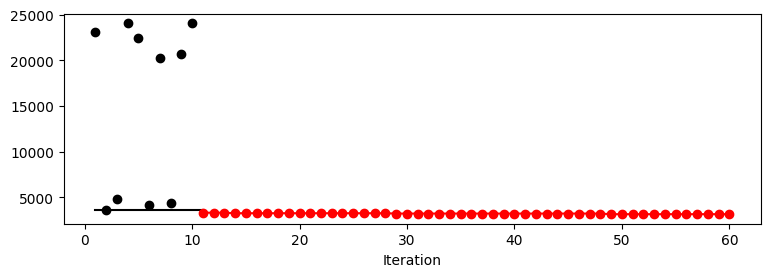

In [ ]:
#| label: 601_plot_progress_1
S.plot_progress()

### Tuned Hyperparameters and Their Importance

Results can be printed in tabular form.

In [ ]:
from spotpython.utils.eda import gen_design_table
print(gen_design_table(fun_control=fun_control, spot=S))

| name           | type   | default   |   lower |   upper | tuned             | transform             |   importance | stars   |
|----------------|--------|-----------|---------|---------|-------------------|-----------------------|--------------|---------|
| l1             | int    | 3         |     3.0 |     4.0 | 3.0               | transform_power_2_int |        18.93 | *       |
| epochs         | int    | 4         |     3.0 |     7.0 | 5.0               | transform_power_2_int |        19.25 | *       |
| batch_size     | int    | 4         |     4.0 |    11.0 | 6.0               | transform_power_2_int |         0.00 |         |
| act_fn         | factor | ReLU      |     0.0 |     5.0 | ReLU              | None                  |         0.00 |         |
| optimizer      | factor | SGD       |     0.0 |     2.0 | Adadelta          | None                  |         1.18 | *       |
| dropout_prob   | float  | 0.01      |     0.0 |   0.025 | 0.025             | None             

A histogram can be used to visualize the most important hyperparameters.

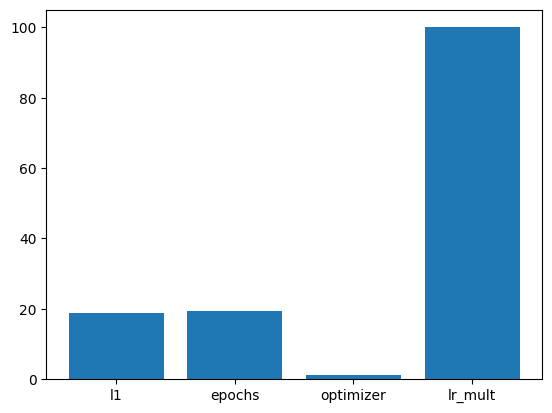

In [ ]:
S.plot_importance(threshold=1.0)

l1:  18.92582347547081
epochs:  19.254078054131366
batch_size:  0.0012439210241905554
act_fn:  0.0012439210241905554
optimizer:  1.1764570775922896
dropout_prob:  0.0019772055551804365
lr_mult:  100.0
patience:  0.007137382766218943
batch_norm:  0.7286986330067262
initialization:  0.0012439210241905554


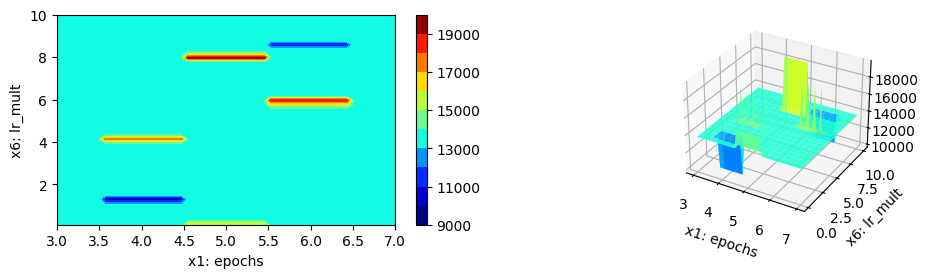

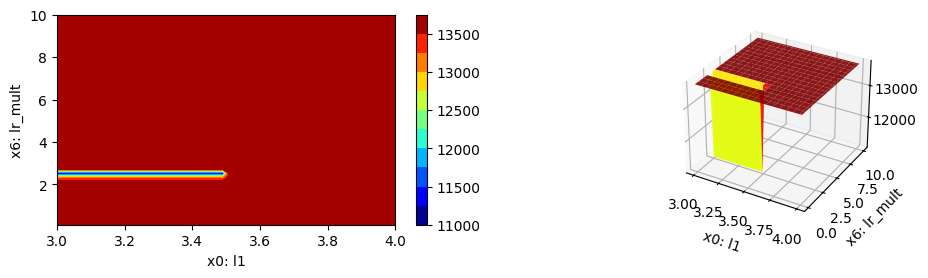

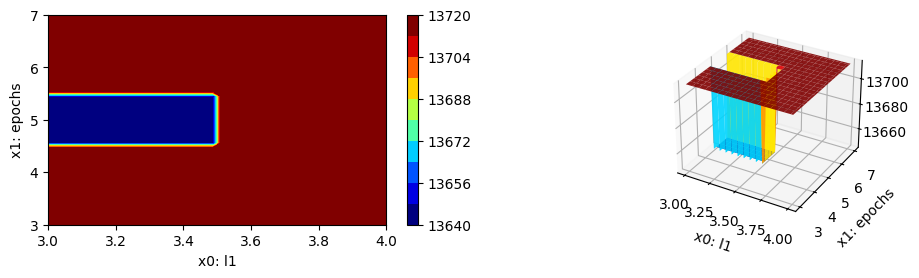

In [ ]:
S.plot_important_hyperparameter_contour(max_imp=3)

### Get the Tuned Architecture {#sec-get-spot-results-601}

In [ ]:
import pprint
from spotpython.hyperparameters.values import get_tuned_architecture
config = get_tuned_architecture(S)
pprint.pprint(config)

{'act_fn': ReLU(),
 'batch_norm': False,
 'batch_size': 64,
 'dropout_prob': 0.025,
 'epochs': 32,
 'initialization': 'kaiming_normal',
 'l1': 8,
 'lr_mult': 4.768940284499347,
 'optimizer': 'Adadelta',
 'patience': 8}


### Test on the full data set

In [ ]:
# set the value of the key "TENSORBOARD_CLEAN" to True in the fun_control dictionary and use the update() method to update the fun_control dictionary
fun_control.update({"TENSORBOARD_CLEAN": True})
fun_control.update({"tensorboard_log": True})

In [ ]:
from spotpython.light.testmodel import test_model
from spotpython.utils.init import get_feature_names

test_model(config, fun_control)
get_feature_names(fun_control)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode
Restoring states from the checkpoint path at /Users/bartz/workspace/Hyperparameter-Tuning-Cookbook/runs/saved_models/8_32_64_ReLU_Adadelta_0.025_4.7689_8_False_kaiming_normal_TEST/epoch=16-step=51.ckpt
Loaded model weights from the checkpoint at /Users/bartz/workspace/Hyperparameter-Tuning-Cookbook/runs/saved_models/8_32_64_ReLU_Adadelta_0.025_4.7689_8_False_kaiming_normal_TEST/epoch=16-step=51.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     3599.204833984375     │
│         val_loss          │     3599.204833984375     │
└───────────────────────────┴───────────────────────────┘

test_model result: {'val_loss': 3599.204833984375, 'hp_metric': 3599.204833984375}


['age',
 'sex',
 'bmi',
 'bp',
 's1_tc',
 's2_ldl',
 's3_hdl',
 's4_tch',
 's5_ltg',
 's6_glu']

## Cross Validation With Lightning

* The `KFold` class from `sklearn.model_selection` is used to generate the folds for cross-validation.
* These mechanism is used to generate the folds for the final evaluation of the model.
* The `CrossValidationDataModule` class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotpython/blob/main/src/spotpython/data/lightcrossvalidationdatamodule.py) is used to generate the folds for the hyperparameter tuning process.
* It is called from the `cv_model` function [[SOURCE]](https://github.com/sequential-parameter-optimization/spotpython/blob/main/src/spotpython/light/cvmodel.py).

In [ ]:
config

{'l1': 8,
 'epochs': 32,
 'batch_size': 64,
 'act_fn': ReLU(),
 'optimizer': 'Adadelta',
 'dropout_prob': 0.025,
 'lr_mult': 4.768940284499347,
 'patience': 8,
 'batch_norm': False,
 'initialization': 'kaiming_normal'}

In [ ]:
from spotpython.light.cvmodel import cv_model
fun_control.update({"k_folds": 2})
fun_control.update({"test_size": 0.6})
cv_model(config, fun_control)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


k: 0


`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 51.9 K | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
51.9 K    Trainable params
0         Non-trainable params
51.9 K    Total params
0.208     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3384.131103515625, 'hp_metric': 3384.131103515625}
k: 1
train_model result: {'val_loss': 3116.005126953125, 'hp_metric': 3116.005126953125}


3250.068115234375

## Extending the Basic Setup

This basic setup can be adapted to user-specific needs in many ways. For example, the user can specify a custom data set, a custom model, or a custom loss function.
The following sections provide more details on how to customize the hyperparameter tuning process.
Before we proceed, we will provide an overview of the basic settings of the hyperparameter tuning process and explain the parameters used so far.

### General Experiment Setup {#sec-general-experiment-setup-601}

To keep track of the different experiments, we use a `PREFIX` for the experiment name. The `PREFIX` is used to create a unique experiment name. The `PREFIX` is also used to create a unique TensorBoard folder, which is used to store the TensorBoard log files.

`spotpython` allows the specification of two different types of stopping criteria: first, the number of function evaluations (`fun_evals`), and second, the maximum run time in seconds (`max_time`). Here, we will set the number of function evaluations to infinity and the maximum run time to one minute.

`max_time` is set to one minute for demonstration purposes. For real experiments, this value should be increased.
Note,  the total run time may exceed the specified `max_time`, because the initial design is always evaluated, even if this takes longer than `max_time`.


### Data Setup {#sec-data-601}

Here, we have provided the `Diabetes` data set class, which is a subclass of `torch.utils.data.Dataset`. 
Data preprocessing is handled by `Lightning` and `PyTorch`. It is described in the [LIGHTNINGDATAMODULE](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) documentation. 

The data splitting, i.e., the generation of training, validation, and testing data, is handled by `Lightning`.


### Objective Function `fun` {#sec-the-objective-function-601}

The objective function `fun` from the class `HyperLight` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotpython/blob/main/src/spotpython/fun/hyperlight.py) is selected next. It implements an interface from `PyTorch`'s training, validation, and testing methods to `spotpython`.

### Core-Model Setup

By using `core_model_name = "light.regression.NNLinearRegressor"`, the `spotpython` model class `NetLightRegression` [[SOURCE]](https://sequential-parameter-optimization.github.io/spotpython/reference/spotpython/light/regression/netlightregression/) from the `light.regression` module is selected.

### Hyperdict Setup

For a given `core_model_name`, the corresponding hyperparameters are automatically loaded from the associated dictionary, which is stored as a JSON file. The JSON file contains hyperparameter type information, names, and bounds. For `spotpython` models, the hyperparameters are stored in the `LightHyperDict`, see [[SOURCE]](https://github.com/sequential-parameter-optimization/spotpython/blob/main/src/spotpython/hyperdict/light_hyper_dict.json)
Alternatively, you can load a local hyper_dict.
The `hyperdict`  uses the default hyperparameter settings. These can be modified as described in @sec-modifying-hyperparameter-levels.

### Other Settings {#sec-other-settings-601}

There are several additional parameters that can be specified, e.g., since we did not specify a loss function, `mean_squared_error` is used, which is the default loss function. These will be explained in more detail in the following sections.


## Tensorboard {#sec-tensorboard-601}

The textual output shown in the console (or code cell) can be visualized with Tensorboard, if the argument `tensorboard_log` to `fun_control_init()` is set to `True`. The Tensorboard log files are stored in the `runs` folder. To start Tensorboard, run the following command in the terminal:


```{raw}
tensorboard --logdir="runs/"
```

Further information can be found in the [PyTorch Lightning documentation](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.loggers.tensorboard.html) for Tensorboard.

## Loading the Saved Experiment and Getting the Hyperparameters of the Tuned Model

To get the tuned hyperparameters as a dictionary, the `get_tuned_architecture` function can be used.

In [ ]:
from spotpython.utils.file import load_result
spot_tuner = load_result(PREFIX=PREFIX)
config = get_tuned_architecture(spot_tuner)
config

Loaded experiment from 601_res.pkl


{'l1': 8,
 'epochs': 32,
 'batch_size': 64,
 'act_fn': ReLU(),
 'optimizer': 'Adadelta',
 'dropout_prob': 0.025,
 'lr_mult': 4.768940284499347,
 'patience': 8,
 'batch_norm': False,
 'initialization': 'kaiming_normal'}

## Using the `spotgui`

The `spotgui` [[github]](https://github.com/sequential-parameter-optimization/spotGUI) provides a convenient way to interact with the hyperparameter tuning process.
To obtain the settings from @sec-basic-setup-601, the `spotgui` can be started as shown in @fig-spotgui.

![spotgui](./figures_static/024_gui.png){width=100% #fig-spotgui}

## Summary

This section presented an introduction to the basic setup of hyperparameter tuning with `spotpython` and `PyTorch` Lightning.
